# Electric-cars-taxation

This is a Jupyter Notebook for creating insights about the taxation around cars.

## Preprocessing

First we'll get some data from the Statistics of Finland. We start by fetching amounts of newly registered regular gasoline cars, tax amounts of gasoline and e-registered cars and cost of living data.

In [1]:
import numpy as np

from requests import post
import pandas as pd

from utils import json_to_text


TARGET = './data_files'
# all the relevant data is saved here and gitignored

from sf_queries import newly_registered_cars_json, car_tax_json, cost_of_living_index_json


cars_newly_registered_90_05 = post('https://pxdata.stat.fi:443/PxWeb/api/v1/fi/StatFin/merek/statfin_merek_pxt_11ck.px',
                 json=newly_registered_cars_json)
# site url: https://pxdata.stat.fi/PxWeb/pxweb/fi/StatFin/StatFin__merek/statfin_merek_pxt_11ck.px/

if cars_newly_registered_90_05:
    # read json retrieved from sf to text file to analyze the data to make dataframe efficiently
    cars_newly_registered_90_05 = cars_newly_registered_90_05.json()

car_taxes = post('https://statfin.stat.fi:443/PxWeb/api/v1/fi/StatFin/vermak/statfin_vermak_pxt_127f.px',
                 json=car_tax_json)

if car_taxes:
    car_taxes = car_taxes.json()

cost_of_living = post('https://statfin.stat.fi:443/PxWeb/api/v1/fi/StatFin/khi/statfin_khi_pxt_11xl.px',
                 json=cost_of_living_index_json)

if cost_of_living:
    cost_of_living = cost_of_living.json()

Next we save the fetched data for non-graphical EDA: 

In [2]:
# read json retrieved from sf to text file to analyze the data to make dataframe efficiently
dest = f'{TARGET}/car_amounts_json.json'
json_to_text(cars_newly_registered_90_05, dest)

dest = f'{TARGET}/car_taxes_json.json'
json_to_text(car_taxes, dest)

dest = f'{TARGET}/cost_of_living.json'
json_to_text(cost_of_living, dest)

JSON data has been successfully written to ./data_files/car_amounts_json.json
JSON data has been successfully written to ./data_files/car_taxes_json.json
JSON data has been successfully written to ./data_files/cost_of_living.json


Based on non-graphical eda, we create dataframes and print it to see that the variables are set.

In [3]:

if cars_newly_registered_90_05:
    newly_registered_years = list(cars_newly_registered_90_05['dimension']['Vuosi']['category']['label'].values())
    newly_registered_amounts = cars_newly_registered_90_05['value']

    e_and_motor_cars = np.array(newly_registered_amounts).reshape(2, 34)

    registered_df = pd.DataFrame({'Year': newly_registered_years,
                                  'Gasoline-cars': e_and_motor_cars[0],
                                  'E-cars': e_and_motor_cars[1]})
    print(registered_df)

if car_taxes:
    car_tax_years = list(car_taxes['dimension']['Vuosi']['category']['label'].values())
    car_tax_amounts = car_taxes['value']

    from_row_vector_to_two_d = np.array(car_tax_amounts).reshape(2, 34)

    sum_of_taxes = np.sum(from_row_vector_to_two_d, axis=0)

    taxes_df = pd.DataFrame({'Year': car_tax_years,
                            'Tax amount (mil)': sum_of_taxes})
    print(taxes_df)

if cost_of_living:
    cost_of_living_months = list(cost_of_living['dimension']['Kuukausi']['category']['label'].values())
    cost_of_living_points = cost_of_living['value']

    # Here we process the cost_of_living to fit our model by taking an avergage of points for each year
    cost_of_living_by_year_totals = {}
    for month, point in zip(cost_of_living_months, cost_of_living_points):
        year = month[:4]
        if year not in cost_of_living_by_year_totals:
            cost_of_living_by_year_totals[year] = point
        else:
            cost_of_living_by_year_totals[year] += point

    col_points = []
    for _, total_points in cost_of_living_by_year_totals.items():
        average = total_points/12
        col_points.append(average)

    cost_of_living_df = pd.DataFrame({'Year': car_tax_years,
                             'Points': col_points})

    print(cost_of_living_df)

    Year  Gasoline-cars  E-cars
0   1990         131830       0
1   1991          87997       2
2   1992          65095       1
3   1993          51465       0
4   1994          63455       0
5   1995          74386       0
6   1996          82878       2
7   1997          89225       0
8   1998         106025       0
9   1999         114295       3
10  2000         108273       0
11  2001          91412       0
12  2002          98837       0
13  2003         125042       0
14  2004         120536       0
15  2005         123020       0
16  2006         116128       0
17  2007          89797       0
18  2008          70317       5
19  2009          48531       1
20  2010          64822      15
21  2011          72128      30
22  2012          66821      51
23  2013          64195      50
24  2014          63969     183
25  2015          69070     243
26  2016          77927     223
27  2017          79034     502
28  2018          84700     776
29  2019          82333    1897
30  2020

Next we make simple arrow diagram for plotting the data retrieved using seaborn.  

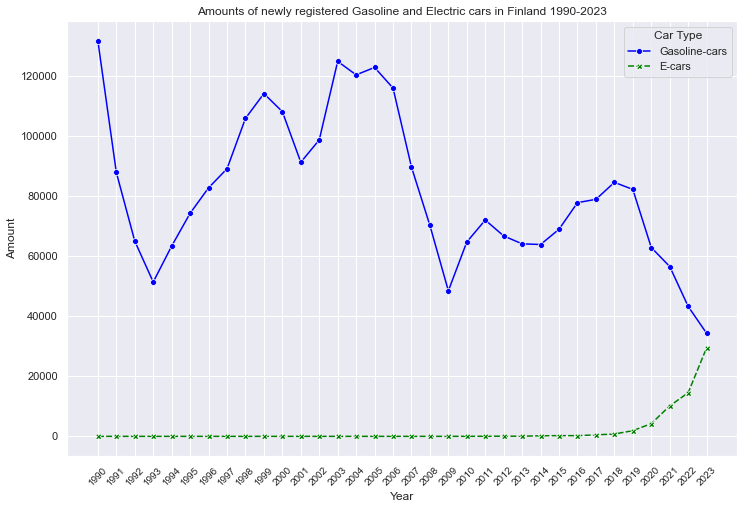

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

registered_long_df = pd.melt(registered_df, id_vars='Year',
                             value_vars=['Gasoline-cars', 'E-cars'],
                             var_name='Car Type', value_name='Amount')

sns.set_theme(style="darkgrid")
plt.figure(figsize=(12, 8))

e_and_gasoline_lines = sns.lineplot(x='Year', y='Amount', hue='Car Type', data=registered_long_df,
             markers=True, style='Car Type', palette=['blue', 'green'])

plt.xticks(rotation=45, fontsize=10)

plt.xlabel('Year')
plt.ylabel('Amount')
plt.title('Amounts of newly registered Gasoline and Electric cars in Finland 1990-2023')

plt.show()


Here we can see that the e- and gasoline cars sales are reaching each other.

Next we plot the tax amounts:

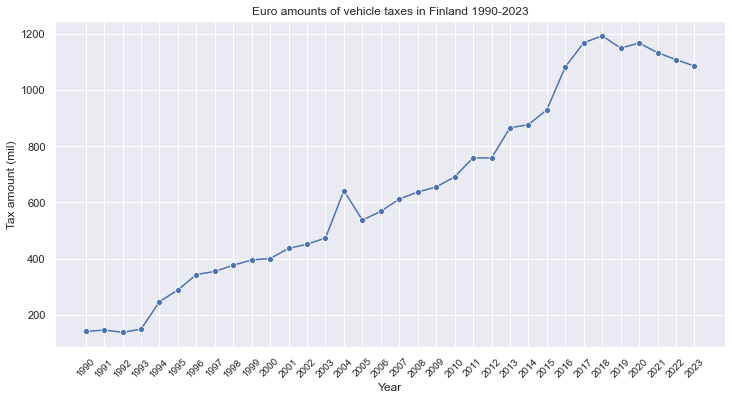

In [5]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(12, 6))

sns.lineplot(x='Year', y='Tax amount (mil)', data=taxes_df, marker='o')

plt.xticks(rotation=45, fontsize=10)

plt.xlabel('Year')
plt.ylabel('Tax amount (mil)')
plt.title('Euro amounts of vehicle taxes in Finland 1990-2023')

plt.show()

Then we plot the cost of living query:

For the cost of living query we take at first average of the index points of each year to fit better to our model and more clear visualization.

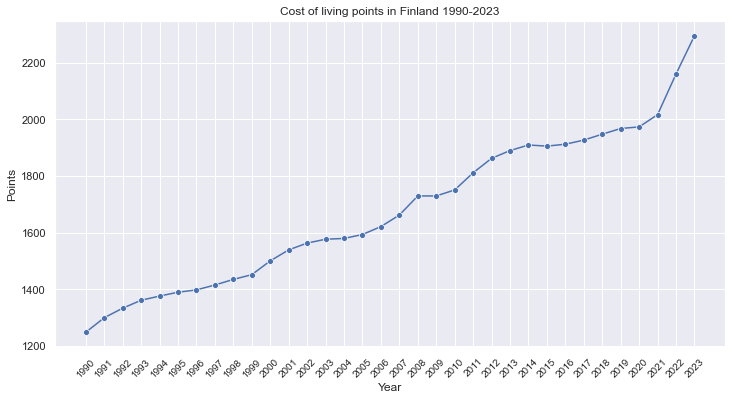

In [6]:
sns.set_theme(style="darkgrid")
plt.figure(figsize=(12, 6))

sns.lineplot(x='Year', y='Points', data=cost_of_living_df, marker='o')

plt.xticks(rotation=45, fontsize=10)

plt.xlabel('Year')
plt.ylabel('Points')
plt.title('Cost of living points in Finland 1990-2023')

plt.show()

Combination of the charts:

    Year       Car Type  Amount
0   1990  Gasoline-cars  131830
1   1991  Gasoline-cars   87997
2   1992  Gasoline-cars   65095
3   1993  Gasoline-cars   51465
4   1994  Gasoline-cars   63455
..   ...            ...     ...
63  2019         E-cars    1897
64  2020         E-cars    4245
65  2021         E-cars   10152
66  2022         E-cars   14531
67  2023         E-cars   29537

[68 rows x 3 columns]


/tmp/ipykernel_2591436/915694955.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


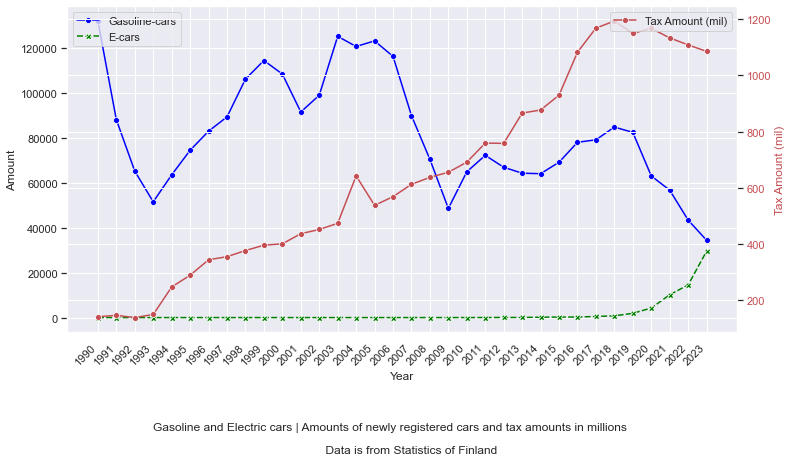

In [7]:
sns.set_theme(style="darkgrid")

plt.figure(figsize=(12, 6))
print(registered_long_df)
ax1 = plt.gca()
sns.lineplot(x='Year', y='Amount', hue='Car Type', data=registered_long_df,
             markers=True, style='Car Type', palette=['blue', 'green'], ax=ax1)

ax1.set_xlabel('Year')
ax1.set_ylabel('Amount')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
sns.lineplot(x='Year', y='Tax amount (mil)', data=taxes_df, marker='o', ax=ax2, color='r', label='Tax Amount (mil)')
ax2.set_ylabel('Tax Amount (mil)', color='r')
ax2.tick_params(axis='y', labelcolor='r')


ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


plt.figtext(0.5, -0.15,'''Gasoline and Electric cars | Amounts of newly registered cars and tax amounts in millions \n
            Data is from Statistics of Finland''',
            wrap=True, horizontalalignment='center', fontsize=12)

plt.show()

The following code uses a **plot_predictions_for_degree** function that generates predictions and plots them for any polynomial degree and creates subplots using **plt**. Subplots plot the results for polynomial degrees 1 (linear) and 2 (quadratic) polynomial regression. The degree is passed as a parameter to the function, which makes the code reusable for different digrees of polynomial features. 

The code trains separate models for polynomial features with degree 1 and degree 2. Then, it predicts and plots the gasoline car sales, e-car sales, and e-car sales based on gasoline data and taxes. The two figures are displayed one below the other for comparison, showing how the degree of the polynomial impacts predictions.

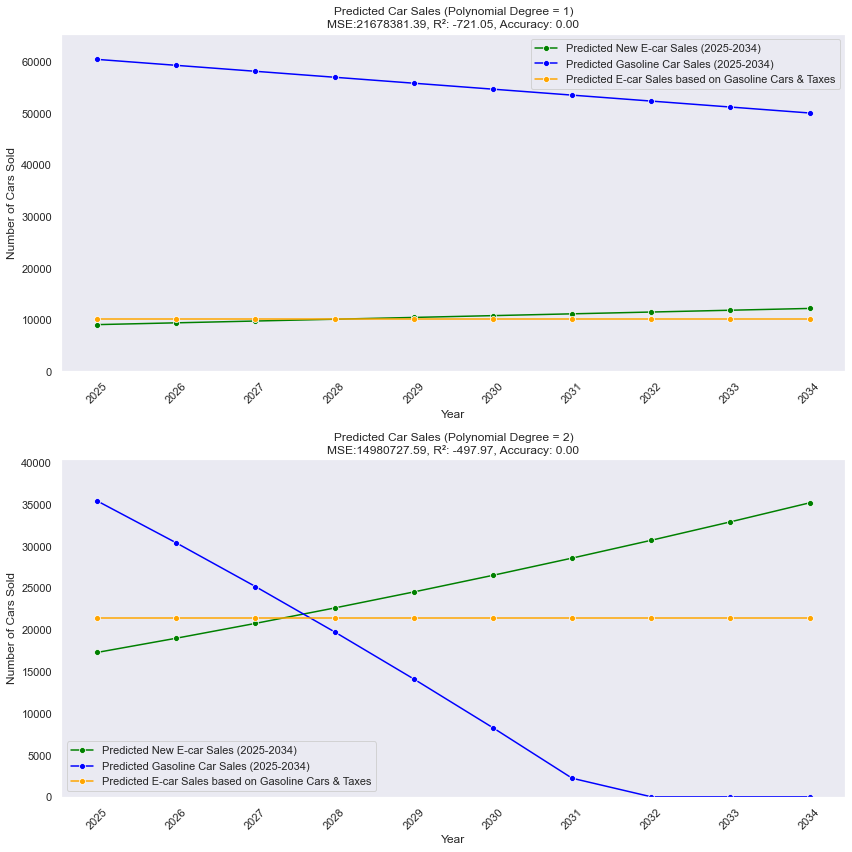

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

# add cumulative gasoline cars column
registered_df['Cumulative Cars'] = registered_df['Gasoline-cars'].cumsum()

# add cumulative e-car column
registered_df['Cumulative Cars'] = registered_df['E-cars'].cumsum()

# define a function to plot predictions and evaluate model for a given degree of polynomial features
def plot_predictions_for_degree(degree, ax):
    # polynomial features for e-cars
    poly_e_car_features = PolynomialFeatures(degree=degree)
    X_e_car = poly_e_car_features.fit_transform(registered_df[['Year']])
    y_e_car = registered_df['E-cars']

    # train polynomial regression model for e-car sales
    X_e_car_train, X_e_car_test, y_e_car_train, y_e_car_test = train_test_split(X_e_car, y_e_car, test_size=0.2, 
        random_state=42)
    poly_reg_e_car = LinearRegression()
    poly_reg_e_car.fit(X_e_car_train, y_e_car_train)

    # predict e-car sales from 2025 to 2034
    future_years = pd.DataFrame({'Year': np.arange(2025, 2035)})
    future_years_poly_e_car = poly_e_car_features.transform(future_years)
    predicted_e_cars_poly = poly_reg_e_car.predict(future_years_poly_e_car)
    predicted_e_cars_poly = np.maximum(predicted_e_cars_poly, 0)

    # polynomial features for gasoline cars
    poly_gasoline = PolynomialFeatures(degree=degree)
    X_gasoline = registered_df[['Year']]
    y_gasoline = registered_df['Gasoline-cars']
    X_gasoline_poly = poly_gasoline.fit_transform(X_gasoline)

    # train polynomial regression model for gasoline car sales
    poly_reg_gasoline = LinearRegression()
    poly_reg_gasoline.fit(X_gasoline_poly, y_gasoline)

    # predict gasoline sales for 2025-2034
    shifted_years = pd.DataFrame({'Year': np.arange(2025, 2035)})
    shifted_years_poly_gasoline = poly_gasoline.transform(shifted_years)
    predicted_gasoline_sales_poly = poly_reg_gasoline.predict(shifted_years_poly_gasoline)
    predicted_gasoline_sales_poly = np.maximum(predicted_gasoline_sales_poly, 0)

    # polynomial features for combined e-car prediction (gasoline cars and taxes)
    e_car_features = pd.DataFrame({
        'Gasoline Cars': registered_df['Gasoline-cars'],
        'Gasoline Tax': taxes_df['Tax amount (mil)']
    })
    poly_combined = PolynomialFeatures(degree=degree)
    X_combined = poly_combined.fit_transform(e_car_features)
    X_combined_train, X_combined_test, y_e_car_train, y_e_car_test = train_test_split(X_combined, y_e_car, 
        test_size=0.2, random_state=42)
    poly_reg_combined = LinearRegression()
    poly_reg_combined.fit(X_combined_train, y_e_car_train)

    # future gasoline data (2025-2034)
    future_gasoline_cars = np.array([registered_df['Gasoline-cars'].iloc[-1]] * 10)
    future_gasoline_tax = np.array([taxes_df['Tax amount (mil)'].iloc[-1]] * 10)

    # future features for combined prediction
    future_combined_features = pd.DataFrame({
        'Gasoline Cars': future_gasoline_cars,
        'Gasoline Tax': future_gasoline_tax
    })
    future_combined_poly = poly_combined.transform(future_combined_features)
    predicted_e_cars_combined = poly_reg_combined.predict(future_combined_poly)
    predicted_e_cars_combined = np.maximum(predicted_e_cars_combined, 0)

    # plot results
    sns.lineplot(x=future_years['Year'], y=predicted_e_cars_poly, label='Predicted New E-car Sales (2025-2034)', 
        ax=ax, color='green', marker='o')
    sns.lineplot(x=shifted_years['Year'], y=predicted_gasoline_sales_poly, 
        label='Predicted Gasoline Car Sales (2025-2034)', ax=ax, color='blue', marker='o')
    sns.lineplot(x=shifted_years['Year'], y=predicted_e_cars_combined, 
        label='Predicted E-car Sales based on Gasoline Cars & Taxes', ax=ax, color='orange', marker='o')

    # evaluate the combined model using test data
    y_pred_sales = poly_reg_combined.predict(X_combined_test)
    mse_sales = mean_squared_error(y_e_car_test, y_pred_sales)
    r2_sales = r2_score(y_e_car_test, y_pred_sales)

    # round predictions for accuracy comparison
    y_pred_sales_rounded = np.round(y_pred_sales)
    y_e_car_test_rounded = np.round(y_e_car_test)
    test_accuracy = accuracy_score(y_e_car_test_rounded, y_pred_sales_rounded)

    # set title and plot
    ax.set_title(f'Predicted Car Sales (Polynomial Degree = {degree})\nMSE:{mse_sales:.2f}, R²: {r2_sales:.2f}, Accuracy: {test_accuracy:.2f}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Cars Sold')
    ax.set_ylim(0, max(max(predicted_e_cars_poly), max(predicted_gasoline_sales_poly), max(predicted_e_cars_combined)) + 5000)
    ax.grid()
    ax.legend()
    ax.set_xticks(np.arange(2025, 2035, 1))
    ax.set_xticklabels(np.arange(2025, 2035, 1), rotation=45)

# create subplots for degree 1 and degree 2
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# plot for polynomial degree 1
plot_predictions_for_degree(degree=1, ax=ax1)

# plot for polynomial degree 2
plot_predictions_for_degree(degree=2, ax=ax2)

# show plots
plt.tight_layout()
plt.show()


The input features are transformed into polynomial terms.
The model fits a linear relationship to these polynomial terms, which results in a polynomial regression model.

The following code will create two figures showing predicted e-car sales for different tax levels, with polynomial degrees 1 and 2, while also including the evaluation metrics on the plots. The predictions for high, medium, and low tax levels are made and plotted for both polynomial degrees.

The function **plot_and_evaluate** handles the creation of polynomial features, model training, predictions, and evaluations for each degree of polynomial features. The evaluation metrics (**Mean Squared Error, R² score, and accuracy**) are calculated using the test data and displayed in each subplot's title.

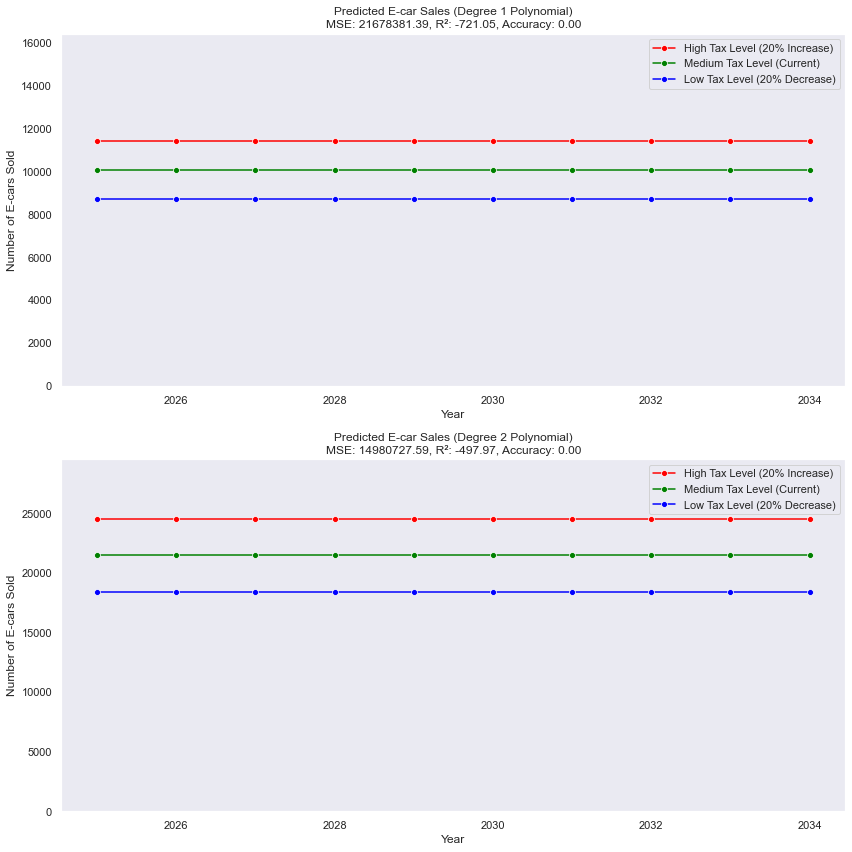

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

# define different tax levels
high_tax = taxes_df['Tax amount (mil)'].iloc[-1] * 1.2  # 20% increase from current tax
medium_tax = taxes_df['Tax amount (mil)'].iloc[-1]      # Current tax level
low_tax = taxes_df['Tax amount (mil)'].iloc[-1] * 0.8   # 20% decrease from current tax

# create future gasoline data (2025-2034), use last known gasoline sales
future_gasoline_cars = np.array([registered_df['Gasoline-cars'].iloc[-1]] * 10)

# define a function to generate polynomial features and predictions, and evaluate model performance
def plot_and_evaluate(degree, ax, title_suffix):
    # create polynomial features for e-cars and gasoline cars
    poly_combined = PolynomialFeatures(degree=degree)
    
    # future combined features for each tax level scenario
    future_combined_features_high = pd.DataFrame({
        'Gasoline Cars': future_gasoline_cars,
        'Gasoline Tax': np.array([high_tax] * 10)
    })
    
    future_combined_features_medium = pd.DataFrame({
        'Gasoline Cars': future_gasoline_cars,
        'Gasoline Tax': np.array([medium_tax] * 10)
    })
    
    future_combined_features_low = pd.DataFrame({
        'Gasoline Cars': future_gasoline_cars,
        'Gasoline Tax': np.array([low_tax] * 10)
    })
    
    # transform features to polynomial form
    future_combined_poly_high = poly_combined.fit_transform(future_combined_features_high)
    future_combined_poly_medium = poly_combined.transform(future_combined_features_medium)
    future_combined_poly_low = poly_combined.transform(future_combined_features_low)

    # train polynomial regression model on historical data
    e_car_features = pd.DataFrame({
        'Gasoline Cars': registered_df['Gasoline-cars'],
        'Gasoline Tax': taxes_df['Tax amount (mil)']
    })
    X_combined = poly_combined.fit_transform(e_car_features)
    y_e_car = registered_df['E-cars']
    X_combined_train, X_combined_test, y_e_car_train, y_e_car_test = train_test_split(X_combined, y_e_car, 
        test_size=0.2, random_state=42)

    poly_reg_combined = LinearRegression()
    poly_reg_combined.fit(X_combined_train, y_e_car_train)

    # predict e-car sales for each tax level scenario
    predicted_e_cars_high = np.maximum(poly_reg_combined.predict(future_combined_poly_high), 0)
    predicted_e_cars_medium = np.maximum(poly_reg_combined.predict(future_combined_poly_medium), 0)
    predicted_e_cars_low = np.maximum(poly_reg_combined.predict(future_combined_poly_low), 0)
    
    # plot predicted e-car sales for different tax levels
    sns.lineplot(x=shifted_years['Year'], y=predicted_e_cars_high, label='High Tax Level (20% Increase)', ax=ax, 
        color='red', marker='o')
    sns.lineplot(x=shifted_years['Year'], y=predicted_e_cars_medium, label='Medium Tax Level (Current)', ax=ax,
        color='green', marker='o')
    sns.lineplot(x=shifted_years['Year'], y=predicted_e_cars_low, label='Low Tax Level (20% Decrease)', ax=ax, 
        color='blue', marker='o')

    # evaluate model for test data (same for all scenarios)
    y_pred_sales = poly_reg_combined.predict(X_combined_test)
    mse_sales = mean_squared_error(y_e_car_test, y_pred_sales)
    r2_sales = r2_score(y_e_car_test, y_pred_sales)
    
    # calculate accuracy with rounded values
    y_pred_sales_rounded = np.round(y_pred_sales)
    y_e_car_test_rounded = np.round(y_e_car_test)
    test_accuracy = accuracy_score(y_e_car_test_rounded, y_pred_sales_rounded)

    # set plot title with evaluation metrics
    ax.set_title(f'Predicted E-car Sales (Degree {degree} {title_suffix})\nMSE: {mse_sales:.2f}, R²: {r2_sales:.2f}, Accuracy: {test_accuracy:.2f}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of E-cars Sold')
    ax.set_ylim(0, max(max(predicted_e_cars_high), max(predicted_e_cars_medium), max(predicted_e_cars_low)) + 5000)
    ax.legend()
    ax.grid()

# create subplots for degree 1 and degree 2
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# plot for polynomial degree 1
plot_and_evaluate(degree=1, ax=ax1, title_suffix="Polynomial")

# plot for polynomial degree 2
plot_and_evaluate(degree=2, ax=ax2, title_suffix="Polynomial")

#show plots
plt.tight_layout()
plt.show()


The following code trains and evaluates polynomial regression models with different degrees (1 and 2) to predict gasoline car and e-car sales for the years 2025-2034 under various tax scenarios (high, medium, and low tax levels). It plots the predicted sales of gasoline cars and e-cars for each tax scenario on two subplots (one for each polynomial degree).

For each scenario, the code calculates and displays evaluation metrics (Mean Squared Error and R-squared) in the subplot titles, showing how well the model predicts e-car sales based on gasoline cars and tax levels.

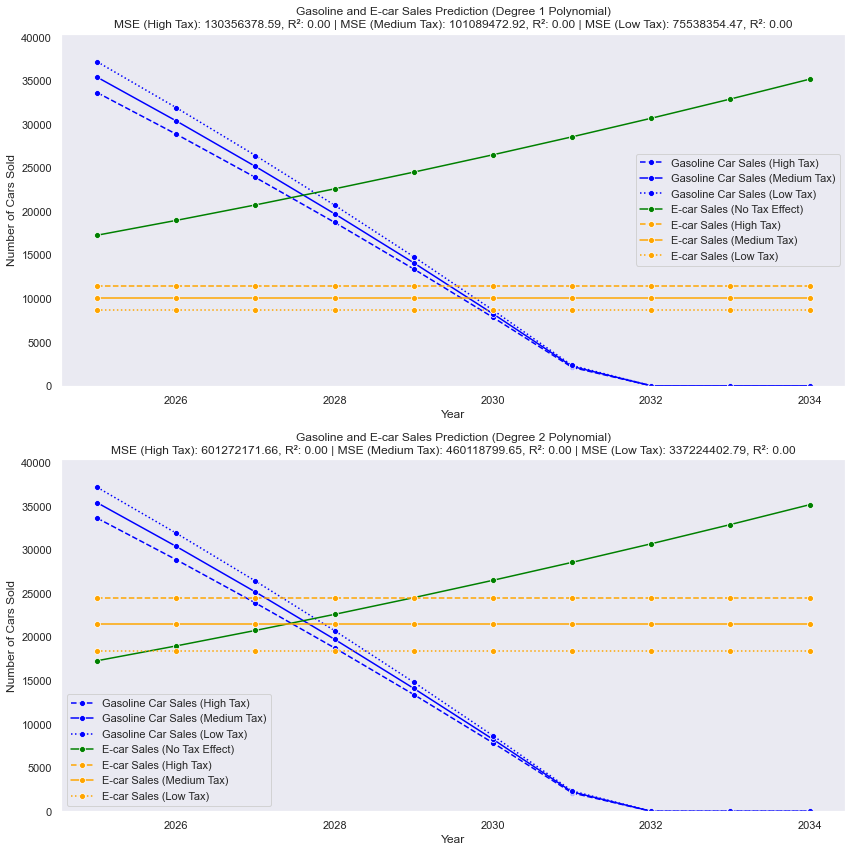

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# define different tax levels
high_tax = taxes_df['Tax amount (mil)'].iloc[-1] * 1.2  # 20% increase from current tax
medium_tax = taxes_df['Tax amount (mil)'].iloc[-1]      # current tax level
low_tax = taxes_df['Tax amount (mil)'].iloc[-1] * 0.8   # 20% decrease from current tax

# function to evaluate and calculate metrics
def evaluate_and_plot_tax_level(X_test, y_test, tax_level_name, color, linestyle, poly_reg_combined, ax):
    # predict using trained model for test data (or future data)
    y_pred_sales = poly_reg_combined.predict(X_test)

    # ensure no negative predictions
    y_pred_sales = np.maximum(y_pred_sales, 0)

    # evaluate using Mean Squared Error (MSE) and R-squared (R²)
    mse_sales = mean_squared_error(y_test, y_pred_sales)
    r2_sales = r2_score(y_test, y_pred_sales)

    # plot predictions
    sns.lineplot(x=future_years['Year'], y=y_pred_sales, label=f'E-car Sales ({tax_level_name} Tax)', 
                 color=color, marker='o', linestyle=linestyle, ax=ax)
    
    # return evaluation metrics to include in plot title
    return mse_sales, r2_sales

# function to train and evaluate models with different polynomial degrees
def train_and_evaluate_poly_model(degree, ax, title_suffix):
    # create polynomial features
    poly_combined = PolynomialFeatures(degree=degree)

    # prepare training data
    e_car_features = pd.DataFrame({
        'Gasoline Cars': registered_df['Gasoline-cars'],
        'Gasoline Tax': taxes_df['Tax amount (mil)']
    })
    X_combined = poly_combined.fit_transform(e_car_features)
    y_e_car = registered_df['E-cars']
    
    # split into train and test sets
    X_combined_train, X_combined_test, y_e_car_train, y_e_car_test = train_test_split(X_combined, y_e_car, 
        test_size=0.2, random_state=42)

    # train polynomial regression model
    poly_reg_combined = LinearRegression()
    poly_reg_combined.fit(X_combined_train, y_e_car_train)

    # future gasoline and tax level features
    future_combined_features_high = pd.DataFrame({
        'Gasoline Cars': np.array([registered_df['Gasoline-cars'].iloc[-1]] * 10),
        'Gasoline Tax': np.array([high_tax] * 10)
    })
    future_combined_features_medium = pd.DataFrame({
        'Gasoline Cars': np.array([registered_df['Gasoline-cars'].iloc[-1]] * 10),
        'Gasoline Tax': np.array([medium_tax] * 10)
    })
    future_combined_features_low = pd.DataFrame({
        'Gasoline Cars': np.array([registered_df['Gasoline-cars'].iloc[-1]] * 10),
        'Gasoline Tax': np.array([low_tax] * 10)
    })

    # transform features to polynomial form
    future_combined_poly_high = poly_combined.transform(future_combined_features_high)
    future_combined_poly_medium = poly_combined.transform(future_combined_features_medium)
    future_combined_poly_low = poly_combined.transform(future_combined_features_low)

    # predict gasoline car sales (adjust for tax levels)
    predicted_gasoline_sales_high_tax = predicted_gasoline_sales_poly * 0.95  # Slight reduction for high tax
    predicted_gasoline_sales_medium_tax = predicted_gasoline_sales_poly * 1.00  # No change for medium tax
    predicted_gasoline_sales_low_tax = predicted_gasoline_sales_poly * 1.05  # Slight increase for low tax

    # plot gasoline car sales
    sns.lineplot(x=future_years['Year'], y=predicted_gasoline_sales_high_tax, 
                 label='Gasoline Car Sales (High Tax)', color='blue', marker='o', linestyle='--', ax=ax)
    sns.lineplot(x=future_years['Year'], y=predicted_gasoline_sales_medium_tax, 
                 label='Gasoline Car Sales (Medium Tax)', color='blue', marker='o', ax=ax)
    sns.lineplot(x=future_years['Year'], y=predicted_gasoline_sales_low_tax, 
                 label='Gasoline Car Sales (Low Tax)', color='blue', marker='o', linestyle=':', ax=ax)

    # predict and plot e-car sales without tax effect
    sns.lineplot(x=future_years['Year'], y=predicted_e_cars_poly, 
                 label='E-car Sales (No Tax Effect)', color='green', marker='o', ax=ax)

    # evaluate and plot e-car sales for different tax levels
    mse_high, r2_high = evaluate_and_plot_tax_level(future_combined_poly_high, np.zeros(10), "High", 'orange', '--',
        poly_reg_combined, ax)
    mse_medium, r2_medium = evaluate_and_plot_tax_level(future_combined_poly_medium, np.zeros(10), "Medium", 
        'orange', '-', poly_reg_combined, ax)
    mse_low, r2_low = evaluate_and_plot_tax_level(future_combined_poly_low, np.zeros(10), "Low", 'orange', ':', 
        poly_reg_combined, ax)

    # set plot title with degree and metrics
    ax.set_title(f'Gasoline and E-car Sales Prediction (Degree {degree} {title_suffix})\n'
                 f'MSE (High Tax): {mse_high:.2f}, R²: {r2_high:.2f} | '
                 f'MSE (Medium Tax): {mse_medium:.2f}, R²: {r2_medium:.2f} | '
                 f'MSE (Low Tax): {mse_low:.2f}, R²: {r2_low:.2f}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Cars Sold')
    ax.set_ylim(0, max(max(predicted_gasoline_sales_poly), max(predicted_gasoline_sales_high_tax)) + 5000)
    ax.legend()
    ax.grid()

# create subplots for polynomial degree 1 and 2
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# plot for polynomial degree 1
train_and_evaluate_poly_model(degree=1, ax=ax1, title_suffix="Polynomial")

# plot for polynomial degree 2
train_and_evaluate_poly_model(degree=2, ax=ax2, title_suffix="Polynomial")

# display plots
plt.tight_layout()
plt.show()

The following approach combines economic and policy factors, making the model more comprehensive in predicting future trends in car sales. 
The cost of living and tax data for 2025-2034 are simply extrapolated (using linear extrapolation in this case). These extrapolated values are used to make predictions for future e-car and gasoline car sales. The feature set and prediction strategy may be further refined by more accurate forecast on taxes and cost of living.  

The model still uses polynomial regression to handle non-linear relationships between car sales and the features (cost of living, taxes, gasoline cars). The fit of the model may be improved by adjusting the degree of the polynomial. The model is evaluated using Mean Squared Error (MSE) and R², and the results are displayed in the plot titles.


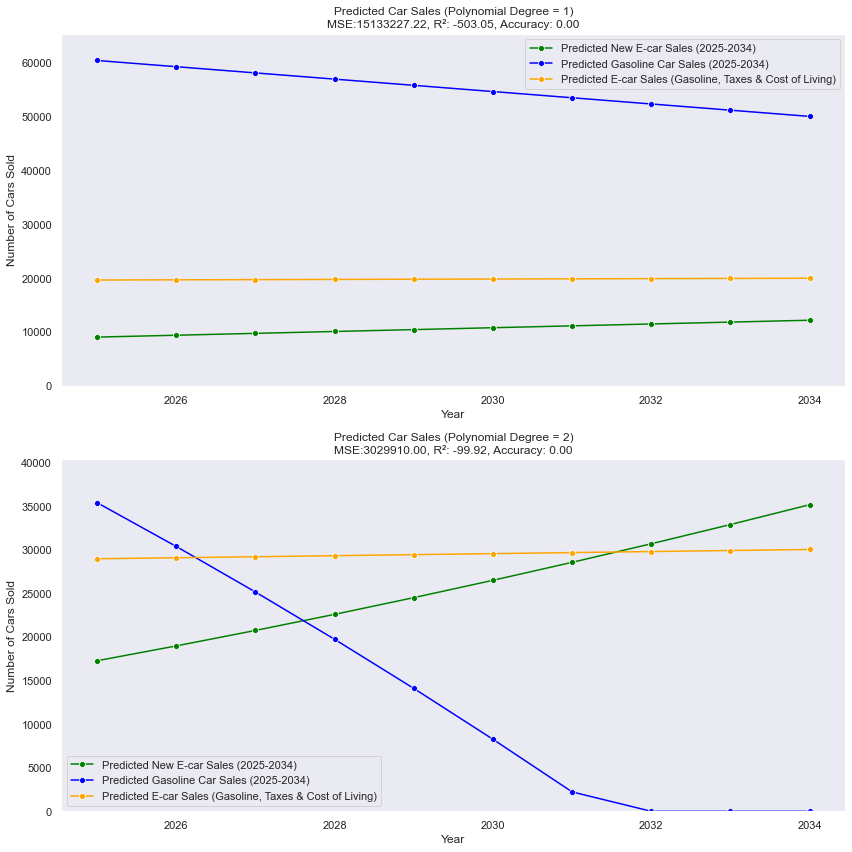

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

# `cost_of_living_df` contains 'Year' and 'Points' for cost of living data
# `taxes_df` contains 'Year' and 'Tax amount (mil)' for taxes data

# extrapolate cost of living and tax data for future years (2025-2034)
future_years = pd.DataFrame({'Year': np.arange(2025, 2035)})

# simple extrapolation for future cost of living and taxes
future_cost_of_living = np.linspace(cost_of_living_df['Points'].iloc[-1], cost_of_living_df['Points'].iloc[-1] + 10, 
    len(future_years))
future_taxes = np.linspace(taxes_df['Tax amount (mil)'].iloc[-1], taxes_df['Tax amount (mil)'].iloc[-1] + 5, 
    len(future_years))

# combine future years, cost of living, and taxes into a dataframe
future_combined_df = pd.DataFrame({
    'Year': future_years['Year'],
    'Cost of Living': future_cost_of_living,
    'Tax amount (mil)': future_taxes
})

# define a function to plot predictions and evaluate model using both taxes and cost of living
def plot_predictions_with_taxes_and_cost_of_living(degree, ax):
    # polynomial features for e-cars
    poly_e_car_features = PolynomialFeatures(degree=degree)
    X_e_car = poly_e_car_features.fit_transform(registered_df[['Year']])
    y_e_car = registered_df['E-cars']

    # train polynomial regression model for e-car sales
    X_e_car_train, X_e_car_test, y_e_car_train, y_e_car_test = train_test_split(X_e_car, y_e_car, test_size=0.2, 
        random_state=42)
    poly_reg_e_car = LinearRegression()
    poly_reg_e_car.fit(X_e_car_train, y_e_car_train)

    # predict e-car sales from 2025 to 2034
    future_years_poly_e_car = poly_e_car_features.transform(future_years)
    predicted_e_cars_poly = poly_reg_e_car.predict(future_years_poly_e_car)
    predicted_e_cars_poly = np.maximum(predicted_e_cars_poly, 0)

    # polynomial features for gasoline cars
    poly_gasoline = PolynomialFeatures(degree=degree)
    X_gasoline = registered_df[['Year']]
    y_gasoline = registered_df['Gasoline-cars']
    X_gasoline_poly = poly_gasoline.fit_transform(X_gasoline)

    # train polynomial regression model for gasoline car sales
    poly_reg_gasoline = LinearRegression()
    poly_reg_gasoline.fit(X_gasoline_poly, y_gasoline)

    # predict gasoline sales for 2025-2034
    shifted_years_poly_gasoline = poly_gasoline.transform(future_years)
    predicted_gasoline_sales_poly = poly_reg_gasoline.predict(shifted_years_poly_gasoline)
    predicted_gasoline_sales_poly = np.maximum(predicted_gasoline_sales_poly, 0)

    # polynomial features for combined e-car prediction (using gasoline cars, taxes, and cost of living)
    combined_features = pd.DataFrame({
        'Gasoline Cars': registered_df['Gasoline-cars'],
        'Cost of Living': cost_of_living_df['Points'],
        'Tax amount (mil)': taxes_df['Tax amount (mil)']
    })
    poly_combined = PolynomialFeatures(degree=degree)
    X_combined = poly_combined.fit_transform(combined_features)
    X_combined_train, X_combined_test, y_e_car_train, y_e_car_test = train_test_split(X_combined, y_e_car, 
        test_size=0.2, random_state=42)
    poly_reg_combined = LinearRegression()
    poly_reg_combined.fit(X_combined_train, y_e_car_train)

    # future features for combined prediction (2025-2034)
    future_combined_features = pd.DataFrame({
        'Gasoline Cars': np.array([registered_df['Gasoline-cars'].iloc[-1]] * 10),  # repeat last gasoline car value
        'Cost of Living': future_cost_of_living,  # Extrapolated cost of living
        'Tax amount (mil)': future_taxes  # Extrapolated taxes
    })
    future_combined_poly = poly_combined.transform(future_combined_features)
    predicted_e_cars_combined = poly_reg_combined.predict(future_combined_poly)
    predicted_e_cars_combined = np.maximum(predicted_e_cars_combined, 0)

    # plot results
    sns.lineplot(x=future_years['Year'], y=predicted_e_cars_poly, label='Predicted New E-car Sales (2025-2034)', 
        ax=ax, color='green', marker='o')
    sns.lineplot(x=future_years['Year'], y=predicted_gasoline_sales_poly, 
        label='Predicted Gasoline Car Sales (2025-2034)', ax=ax, color='blue', marker='o')
    sns.lineplot(x=future_years['Year'], y=predicted_e_cars_combined, 
        label='Predicted E-car Sales (Gasoline, Taxes & Cost of Living)', ax=ax, color='orange', marker='o')

    # evaluate combined model using test data
    y_pred_sales = poly_reg_combined.predict(X_combined_test)
    mse_sales = mean_squared_error(y_e_car_test, y_pred_sales)
    r2_sales = r2_score(y_e_car_test, y_pred_sales)
    
    # round predictions for accuracy comparison
    y_pred_sales_rounded = np.round(y_pred_sales)
    y_e_car_test_rounded = np.round(y_e_car_test)
    test_accuracy = accuracy_score(y_e_car_test_rounded, y_pred_sales_rounded)

    # set title and plot
    ax.set_title(f'Predicted Car Sales (Polynomial Degree = {degree})\nMSE:{mse_sales:.2f}, R²: {r2_sales:.2f}, Accuracy: {test_accuracy:.2f}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Cars Sold')
    ax.set_ylim(0, max(max(predicted_e_cars_poly), max(predicted_gasoline_sales_poly), 
        max(predicted_e_cars_combined)) + 5000)
    ax.grid()
    ax.legend()

# create subplots for polynomial degrees
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# plot for polynomial degree 1
plot_predictions_with_taxes_and_cost_of_living(degree=1, ax=ax1)

# plot for polynomial degree 2
plot_predictions_with_taxes_and_cost_of_living(degree=2, ax=ax2)

# show plots
plt.tight_layout()
plt.show()